In [1]:
from dotenv import load_dotenv
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from tqdm.notebook import tqdm_notebook
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


In [10]:
load_dotenv();

In [3]:
loader = TextLoader("./data/dogs.txt")
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=300, chunk_overlap=25)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 411, which is longer than the specified 300
Created a chunk of size 301, which is longer than the specified 300


In [4]:
# RAGAS expects a file_name dict as key
for document in chunks:
    document.metadata['filename'] = document.metadata['source']

### Eval with Ragas

In [5]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context

In [6]:
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
critic_llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
embeddings = OpenAIEmbeddings()


In [7]:
generator = TestsetGenerator.from_langchain(
    generator_llm, critic_llm, embeddings
)


In [ ]:
testset = generator.generate_with_langchain_docs(chunks, test_size=10, distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25});

In [9]:
testset.to_pandas()

,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What inspired Sir Purrington to found the Feli...,[In the heart of the bustling city of Whiskerv...,Sir Purrington was inspired to found the Felin...,simple,"[{'source': './data/dogs.txt', 'filename': './...",True
1,How is the bank described as a haven of tranqu...,"[Inside, the bank was a haven of tranquility a...",The bank is described as a haven of tranquilit...,simple,"[{'source': './data/dogs.txt', 'filename': './...",True
2,What was the role of the feline warriors in gu...,[The most popular feature was the high-securit...,nan,simple,"[{'source': './data/dogs.txt', 'filename': './...",True
3,What was the purpose of the high-security vaul...,[The most popular feature was the high-securit...,The purpose of the high-security vault for cat...,simple,"[{'source': './data/dogs.txt', 'filename': './...",True
4,Who founded the Feline Financial Bank in Whisk...,[In the heart of the bustling city of Whiskerv...,Sir Purrington founded the Feline Financial Ba...,simple,"[{'source': './data/dogs.txt', 'filename': './...",True
5,How was the Feline Financial Bank designed for...,[In the heart of the bustling city of Whiskerv...,The Feline Financial Bank was designed with a ...,reasoning,"[{'source': './data/dogs.txt', 'filename': './...",True
6,How secure was the bank's repository?,[The most popular feature was the high-securit...,The most popular feature was the high-security...,multi_context,"[{'source': './data/dogs.txt', 'filename': './...",True
7,How was the high-security vault guarded?,[The most popular feature was the high-securit...,The high-security vault was guarded by the bra...,multi_context,"[{'source': './data/dogs.txt', 'filename': './...",True


In [12]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI()

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [20]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f3ab5c5b6a0>)

In [16]:
vectorstore.get(include=["embeddings"])

{'ids': ['2facacc8-7e82-46a7-875d-0d9ce46a0e8e',
  '39e39ed5-b046-403f-97f9-611ba9dc0186',
  '56208049-18a8-47aa-8a30-b9bbb987874c',
  '95fef816-948c-4b79-a423-41603d2e49ee',
  '9cd487ae-7bd6-4607-8f11-8b6bf806c3ac'],
 'embeddings': [[-0.0027196998707950115,
   -0.006753412075340748,
   -0.002621233928948641,
   -0.008447706699371338,
   -0.005093071144074202,
   0.01670527085661888,
   -0.013296310789883137,
   -0.01290244609117508,
   -0.0018606685334816575,
   -0.03626266121864319,
   0.031210338696837425,
   0.015252050012350082,
   0.0032782400958240032,
   0.005327352322638035,
   -0.010804100893437862,
   -0.0012800585245713592,
   0.02484060451388359,
   -0.007367976009845734,
   0.003283333033323288,
   -0.030775729566812515,
   -0.038136910647153854,
   0.011944948695600033,
   -0.02712230011820793,
   -0.0023105563595891,
   -0.0056668901816010475,
   0.008916269056499004,
   0.010423818603157997,
   -0.0152656314894557,
   -0.0029047480784356594,
   0.019041292369365692,
  

In [17]:
len(vectorstore.get(include=["embeddings"])['embeddings'])

5

In [18]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context","question"]
  )

#### Chain

In [19]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [21]:
questions = testset.to_pandas()["question"].to_list()
ground_truth = testset.to_pandas()["ground_truth"].to_list()

In [24]:
questions[0], ground_truth[0]

('What inspired Sir Purrington to found the Feline Financial Bank, a bank exclusively for cats, in Whiskerville?',
 'Sir Purrington was inspired to found the Feline Financial Bank in Whiskerville because he believed that every feline deserved a place to secure their precious belongings, such as toys, catnip, and tuna treats. He wanted to provide a safe and exclusive space for cats to store their valuables.')

In [29]:
from datasets import Dataset


In [30]:
data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

In [31]:
for query in questions:
    data['question'].append(query)
    data['answer'].append(rag_chain.invoke(query))
    data['contexts'].append([doc.page_content for doc in retriever.get_relevant_documents(query)])

In [32]:
dataset = Dataset.from_dict(data)

In [35]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_relevancy,
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

In [36]:
result.to_pandas()

/home/peter-legion-wsl2/peter-projects/daybreak-ml-docs/.venv/lib/python3.10/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  tables (list of `Table` or list of `pyarrow.Table`):
/home/peter-legion-wsl2/peter-projects/daybreak-ml-docs/.venv/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  Make sure each row_block contain the same num_rows to be able to concatenate them on axis=1.


,question,answer,contexts,ground_truth,context_relevancy,context_precision,context_recall,faithfulness,answer_relevancy
0,What inspired Sir Purrington to found the Feli...,Sir Purrington was inspired to found the Felin...,[In the heart of the bustling city of Whiskerv...,Sir Purrington was inspired to found the Felin...,0.111111,1.00,1.0,1.0,0.967360
1,How is the bank described as a haven of tranqu...,The bank is described as a haven of tranquilit...,"[Inside, the bank was a haven of tranquility a...",The bank is described as a haven of tranquilit...,0.111111,1.00,0.5,1.0,0.831251
2,What was the role of the feline warriors in gu...,The role of the feline warriors was to guard t...,[The most popular feature was the high-securit...,nan,0.111111,0.00,0.0,1.0,0.936892
3,What was the purpose of the high-security vaul...,The purpose of the high-security vault for cat...,[The most popular feature was the high-securit...,The purpose of the high-security vault for cat...,0.111111,0.75,1.0,1.0,0.959182
4,Who founded the Feline Financial Bank in Whisk...,Sir Purrington founded the Feline Financial Ba...,[In the heart of the bustling city of Whiskerv...,Sir Purrington founded the Feline Financial Ba...,0.111111,1.00,1.0,1.0,0.999999
5,How was the Feline Financial Bank designed for...,The Feline Financial Bank was designed for all...,[Feline Financial Bank was not just a bank; it...,The Feline Financial Bank was designed with a ...,0.111111,1.00,1.0,1.0,0.899129
6,How secure was the bank's repository?,The bank's repository was said to be impenetra...,[The most popular feature was the high-securit...,The most popular feature was the high-security...,0.100000,1.00,1.0,1.0,0.931497
7,How was the high-security vault guarded?,The high-security vault was guarded by the bra...,[The most popular feature was the high-securit...,The high-security vault was guarded by the bra...,0.100000,1.00,1.0,1.0,0.966198


In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[['context_relevancy', 'context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']]

/home/peter-legion-wsl2/peter-projects/daybreak-ml-docs/.venv/lib/python3.10/site-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  tables (list of `Table` or list of `pyarrow.Table`):
/home/peter-legion-wsl2/peter-projects/daybreak-ml-docs/.venv/lib/python3.10/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  Make sure each row_block contain the same num_rows to be able to concatenate them on axis=1.


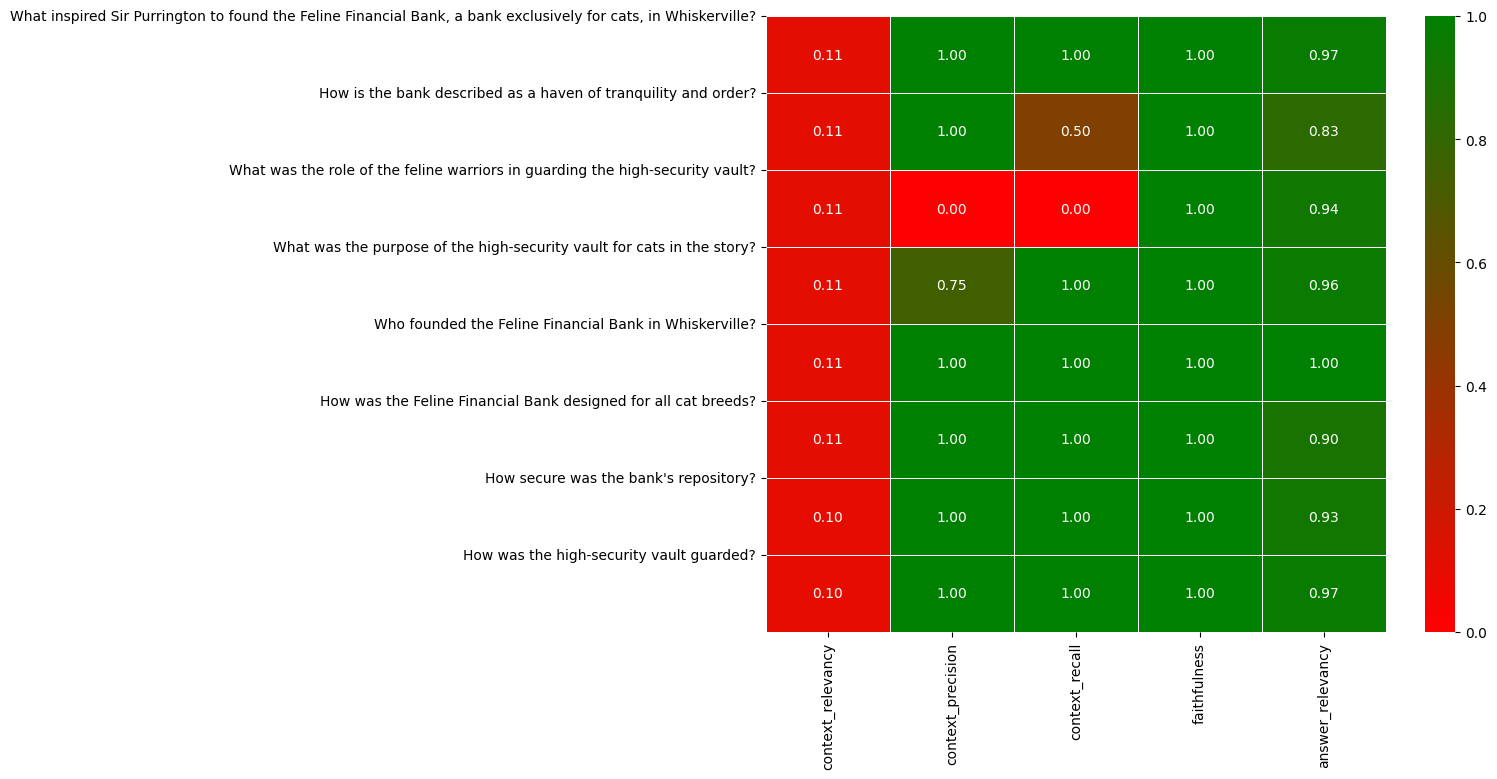

In [38]:
cmap = LinearSegmentedColormap.from_list('green_red', ['red', 'green'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap=cmap)

plt.yticks(ticks=range(len(df['question'])), labels=df['question'], rotation=0)

plt.show()

### Add LangFuse

In [ ]:
import os
from langfuse import Langfuse

langfuse = Langfuse(
  secret_key=os.environ.get("LANGFUSE_SECRET_KEY")
  public_key=os.environ.get("LANGFUSE_PUBLIC_KEY")
  host="http://localhost:3000"
)

In [ ]:
trace = langfuse.trace(
    name = "eval",
    user_id = "eval_user",
    metadata = {
        "email": "prod@company.com",
    },
    tags = ["evaluation"]
)

In [ ]:
df = result.to_pandas()

In [ ]:
for _, row in df.iterrows():
    for metric_name in ["faithfulness", "answer_relevancy", "context_recall"]:
        langfuse.score(
            name=metric_name,
            value=row[metric_name],
            trace_id=trace.id
        )